In [577]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from typing import Optional
from data.utils import load_data

In [586]:
models = ['KroeneckerGP','SimpleGP2','SeasonalES', 'ES', 'Yesterday', 'Persistence', 'Hourly', 'VAR']
df_dict = {}
for model in models:
    print(model)
    df_dict[model] = load_data('Dissertation/reports/temporal2hr', f'{model}.csv')
    df_dict[model].drop(columns=['Unnamed: 0'], inplace=True)

# rename SeasonalES to SES, Yesterday to Y.Day, Hourly to H Avg, Persistence to Prst.
df_dict['SES'] = df_dict.pop('SeasonalES')
df_dict['Y.Day'] = df_dict.pop('Yesterday')
df_dict['H Avg'] = df_dict.pop('Hourly')
df_dict['Prst.'] = df_dict.pop('Persistence')
df_dict['Kr.GP'] = df_dict.pop('KroeneckerGP')
df_dict['GP'] = df_dict.pop('SimpleGP2') 


KroeneckerGP
==> Loading data
==> Loaded data in: 0 m : 0 sec

SimpleGP2
==> Loading data
==> Loaded data in: 0 m : 0 sec

SeasonalES
==> Loading data
==> Loaded data in: 0 m : 0 sec

ES
==> Loading data
==> Loaded data in: 0 m : 0 sec

Yesterday
==> Loading data
==> Loaded data in: 0 m : 0 sec

Persistence
==> Loading data
==> Loaded data in: 0 m : 0 sec

Hourly
==> Loading data
==> Loaded data in: 0 m : 0 sec

VAR
==> Loading data
==> Loaded data in: 0 m : 0 sec



In [587]:
nlpd_dict = {}
models = ['KroeneckerGP', 'SimpleGP2','SeasonalES', 'ES']
for model in models:
    print(model)
    nlpd_dict[model] = load_data('Dissertation/reports/temporal2hr', f'{model}_nlpd.csv')
    nlpd_dict[model].drop(columns=['Unnamed: 0'], inplace=True)

# rename SeasonalES to SES, 
nlpd_dict['SES'] = nlpd_dict.pop('SeasonalES')
nlpd_dict['Kr.GP'] = nlpd_dict.pop('KroeneckerGP')
nlpd_dict['GP'] = nlpd_dict.pop('SimpleGP2')

# one outlier in SES to remove (nlpd = 7500)
df_ses = nlpd_dict['SES']
df_ses[df_ses == df_ses.max().max()] = np.nan
nlpd_dict['SES'] = df_ses


KroeneckerGP
==> Loading data
==> Loaded data in: 0 m : 0 sec

SimpleGP2
==> Loading data
==> Loaded data in: 0 m : 0 sec

SeasonalES
==> Loading data
==> Loaded data in: 0 m : 0 sec

ES
==> Loading data
==> Loaded data in: 0 m : 0 sec



In [588]:
def plot_forecast_mae(ax, results : dict, season : Optional[str] = None, pred_points=24):
    cmap = sns.color_palette(palette='tab10')
    colors = [cmap[i] for i in range(len(results.keys()))]
    linestyles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.', ':']

    plt.rcParams.update({'font.family': 'Arial'})
    
    for i, key in enumerate(results.keys()):
        mean = results[key]['mean']
        ax.plot(np.arange(0, pred_points), mean, color=colors[i], linestyle=linestyles[i], label=key)
    title = season.upper()[0] + season[1:]
    ax.set_title(title, fontsize=20)

In [589]:
def boxplot_models(ax, results : dict):    
    ax.boxplot([results[key]['mean'] for key in results.keys()], labels=results.keys(), showmeans=True)
    

In [590]:
def print_mae_table(dct, models, season : Optional[str] = None):
    """ 
    Print table with MAE
    """
    if season:
        print('-'*35)
        print(f'{" "*10} {season.upper()} {" "*10}')
    print('-'*35)
    print('| Model \t| MAE \t | STD Dev ')
    print('-'*35)
    for model in models:
        mae = dct[model].mean(axis=1).mean()
        std = dct[model].std(axis=1).mean()
        if model in ['ES', 'VAR', 'SES', 'GP']:
            print(f'| {model} \t\t | {mae:.3f} | {std:.3f} ')
        else:
            print(f'| {model} \t | {mae:.3f} | {std:.3f} ')
        

In [591]:
def print_nlpd_table(nlpd_dict, season : Optional[str] = None):
    dct = nlpd_dict.copy()
    if season:
        print('-'*35)
        print(f'{" "*10} {season.upper()} {" "*10}')
    print('-'*35)
    print('| Model | NLPD   | STD Dev ')
    print('-'*35)

    for model in dct.keys():
        # we have 1/N * p(y_i | theta_i)), so we sum column-wise to get NLPD
        # sum all rows column-wise
        dct[model] = dct[model].sum()
        mae = dct[model].median()
        std = dct[model].std()
        if model == 'Kr.GP':
            print(f'| {model} | {mae:.3f} | {std:.6f} ')
        
        else:
            print(f'| {model} \t| {mae:.3f} | {std:.6f} ')

In [592]:
print_nlpd_table(nlpd_dict)

-----------------------------------
| Model | NLPD   | STD Dev 
-----------------------------------
| ES 	| -0.421 | 0.973168 
| SES 	| -0.441 | 1.224037 
| Kr.GP | -0.491 | 1.064440 
| GP 	| -0.485 | 1.374661 


In [593]:
print_mae_table(df_dict, df_dict.keys())

-----------------------------------
| Model 	| MAE 	 | STD Dev 
-----------------------------------
| ES 		 | 0.107 | 0.127 
| VAR 		 | 0.100 | 0.100 
| SES 		 | 0.106 | 0.116 
| Y.Day 	 | 0.176 | 0.180 
| H Avg 	 | 0.118 | 0.126 
| Prst. 	 | 0.108 | 0.129 
| Kr.GP 	 | 0.116 | 0.113 
| GP 		 | 0.145 | 0.138 


In [594]:
# we have 52 weeks and 6 systems --> 52*6 = 312 "weeks" in total starting from 1. Jan 2018

def winter_idx(experiment_idx, n_systems=6):
    return [idx for idx in experiment_idx if idx <= 9*n_systems or idx > 48*n_systems]

def spring_idx(experiment_idx, n_systems=6):
    return [idx for idx in experiment_idx if idx > 9*n_systems and idx <= 22*n_systems]

def summer_idx(experiment_idx, n_systems=6):
    return [idx for idx in experiment_idx if idx > 22*n_systems and idx <= 35*n_systems]

def autumn_idx(experiment_idx, n_systems=6):
    return [idx for idx in experiment_idx if idx > 35*n_systems and idx <= 48*n_systems]

def filter_season(df_dict, models, season, split_str: str = 'mae', forecast_horizon : Optional[int] = None):
    
    filtered = {}
    experiment_idx = [int((col.split(split_str)[-1])) if len(col.split(split_str)) > 1 else -1 for col in df_dict[models[0]].columns]
    if season == 'winter':
        idx = winter_idx(experiment_idx)
    elif season == 'spring':
        idx = spring_idx(experiment_idx)
    
    elif season == 'summer':
        idx = summer_idx(experiment_idx)
    
    elif season == 'autumn':
        idx = autumn_idx(experiment_idx)
    else:
        raise ValueError('Season must be one of: winter, spring, summer, autumn')
    
    for model in models:
        try:
            if forecast_horizon:
                filtered[model] = df_dict[model].iloc[:forecast_horizon, idx]
            else:
                filtered[model] = df_dict[model].iloc[:, idx]
        except IndexError:
            idx = [i for i in idx if i < df_dict[model].shape[1]]
            if forecast_horizon:
                filtered[model] = df_dict[model].iloc[:forecast_horizon, idx]
            else:
                filtered[model] = df_dict[model].iloc[:, idx]
    
    for model in models:
        if 'Unnamed: 0' in filtered[model].columns:
            # ignore SettingWithCopyWarning
            with pd.option_context('mode.chained_assignment', None):
                filtered[model].drop('Unnamed: 0', axis=1, inplace=True)

    return filtered

-----------------------------------
           SPRING           
-----------------------------------
| Model 	| MAE 	 | STD Dev 
-----------------------------------
| Kr.GP 	 | 0.140 | 0.126 
| GP 		 | 0.174 | 0.147 
| SES 		 | 0.121 | 0.123 
| ES 		 | 0.133 | 0.140 
| Y.Day 	 | 0.200 | 0.181 
| Prst. 	 | 0.132 | 0.143 
| H Avg 	 | 0.145 | 0.140 
| VAR 		 | 0.122 | 0.114 
-----------------------------------
           SPRING           
-----------------------------------
| Model | NLPD   | STD Dev 
-----------------------------------
| Kr.GP | -0.315 | 0.981446 
| GP 	| -0.206 | 0.701995 
| SES 	| -0.416 | 1.286465 
| ES 	| -0.370 | 1.340369 
-----------------------------------
           SUMMER           
-----------------------------------
| Model 	| MAE 	 | STD Dev 
-----------------------------------
| Kr.GP 	 | 0.142 | 0.111 
| GP 		 | 0.191 | 0.137 
| SES 		 | 0.128 | 0.120 
| ES 		 | 0.119 | 0.127 
| Y.Day 	 | 0.229 | 0.212 
| Prst. 	 | 0.121 | 0.128 
| H Avg 	 | 0.139 | 0.126 


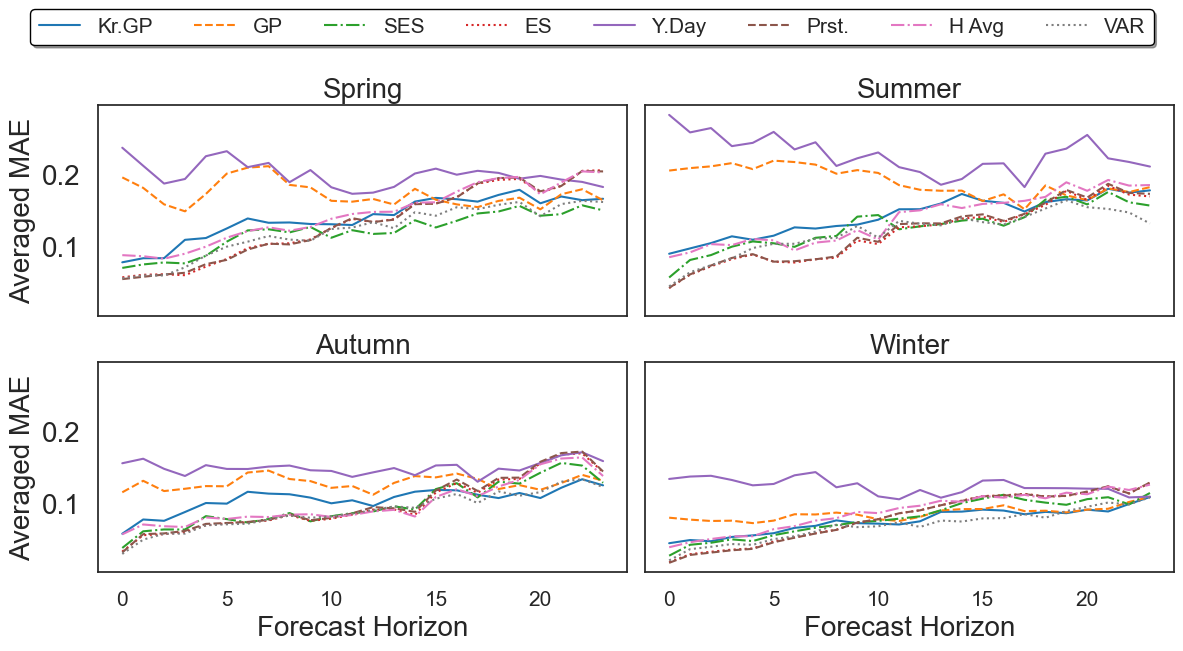

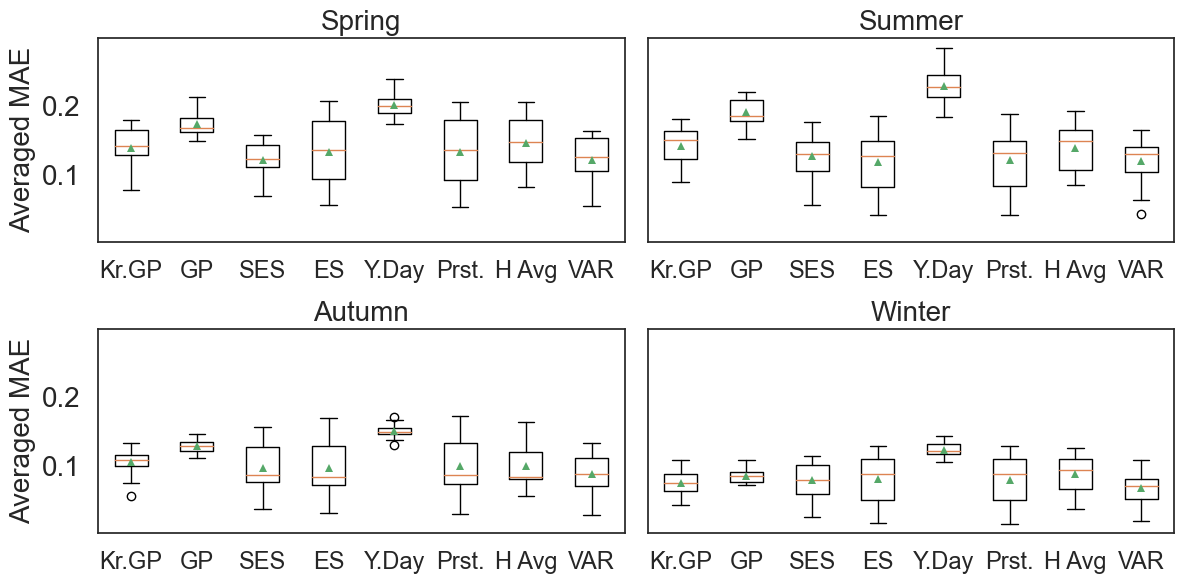

In [595]:
from metrics import get_mean_ci
plt.rcParams.update({'font.family': 'Arial'})
fig, ax = plt.subplots(2, 2, figsize=(12, 6), sharex=True, sharey=True)
fig2, ax2 = plt.subplots(2, 2, figsize=(12, 6), sharex=False, sharey=True)

ax = ax.flatten()
ax2 = ax2.flatten()
# change horizon to 24 for 2hr and 72 for 6hr
horizon = 24
hour = horizon // 12
models = ['Kr.GP','GP','SES', 'ES', 'Y.Day', 'Prst.', 'H Avg', 'VAR']
models_nlpd = ['Kr.GP', 'GP','SES', 'ES']

for i, season in enumerate(['spring', 'summer', 'autumn', 'winter']):
    # change split string of dict_season to 'mae' for 6hr and '_' for 2hr
    dict_season = filter_season(df_dict, models, season, forecast_horizon=horizon, split_str='mae')
    nlpd_season = filter_season(nlpd_dict, models_nlpd, season, split_str='nlpd', forecast_horizon=horizon)
    results = {}
    print_mae_table(dict_season, models, season)
    print_nlpd_table(nlpd_season, season)
    for model in dict_season.keys():
        mean, lower, upper = get_mean_ci(dict_season[model])
        results[model] = {'mean': mean, 'lower': lower, 'upper': upper}

    plot_forecast_mae(ax[i], results, pred_points=mean.shape[0], season=season)
    boxplot_models(ax2[i], results)

    title = season.upper()[0] + season[1:]
    ax2[i].set_title(title, fontsize=20)
    
    if i == 0:
        # get legends and set at the top middle of the entire figure instead of each subplot
        # set it in a shaded box with edgecolor='black'
        handles, labels = ax[i].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', ncol=len(df_dict.keys()), fontsize=15,
                     bbox_to_anchor=(0.5, 1.1), fancybox=True, shadow=True, edgecolor='black',
                     frameon=True, framealpha=1.0)
    
    # set ylabel only for left plots
    if i % 2 == 0:
        ax[i].set_ylabel('Averaged MAE', fontsize=20)
        ax2[i].set_ylabel('Averaged MAE', fontsize=20)
        # set size of yticks
        ax[i].yaxis.set_tick_params(labelsize=20)
        ax2[i].yaxis.set_tick_params(labelsize=20)

        
    
    # set xlabel only for bottom plots
    if i >= 2:
        ax[i].set_xticks(np.arange(0, len(mean), 5), np.arange(0, len(mean) + 1, 5), fontsize=15)

        ax[i].set_xlabel('Forecast Horizon', fontsize=20)



# set xticks for to be the models for the boxplots
for i in range(4):
    ax2[i].set_xticks(np.arange(1, len(models)+1), models, fontsize=17)

fig.tight_layout()
fig2.tight_layout()
fig.savefig('lineplot.png', dpi=300, bbox_inches='tight')
fig2.savefig('boxplot.png', dpi=300, bbox_inches='tight')


In [553]:
from typing import Optional
import seaborn as sns

def boxplot_forecast_horizon(df_dict, season : Optional[str] = None):
    
    fig, ax = plt.subplots(len(df_dict) // 2, 3, figsize=(20, 6), sharey=True, sharex=False)
    plt.rcParams.update({'font.family': 'Arial'})
    ax = ax.flatten()
    pred_points = df_dict[list(df_dict.keys())[0]].shape[0]
    print(pred_points)
    for i,  (key, df) in enumerate(df_dict.items()):
        df_transposed = df.T
        sns.boxplot(data=df_transposed, ax=ax[i], 
                    showfliers=False,
                    medianprops={'color':'b', },
                    showmeans=True, color='white', 
                    meanprops={'marker':'^','markerfacecolor':'red'},)
        
        ax[i].set_title(key, fontsize=25)
        if i % 3 == 0:
            ax[i].set_ylabel('MAE Errors', fontsize=25)
            ax[i].yaxis.set_tick_params(labelsize=25)
        if pred_points <= 24:
            ax[i].set_xticks(np.arange(0, pred_points, 5), np.arange(0, pred_points + 1, 5), fontsize=20)
            ax[i].xaxis.set_tick_params(labelsize=25)
        else:
            ax[i].set_xticks(np.arange(0, pred_points, 10), np.arange(0, pred_points + 1, 10), fontsize=20)
            ax[i].xaxis.set_tick_params(labelsize=25)


        ax[i].set_xlabel('Forecast Steps', fontsize=25)
      

    # remove unused plots
    if len(df_dict) % 3 != 0:
        ax[-1].remove()
        
    hour = pred_points // 12
    plt.tight_layout()
    plt.savefig(f'forecast_temporal.png', dpi=300, bbox_inches='tight')
    plt.show();

In [554]:
best_model_dict = {model : df_dict[model] for model in ['Kr.GP','GP', 'VAR']}


24


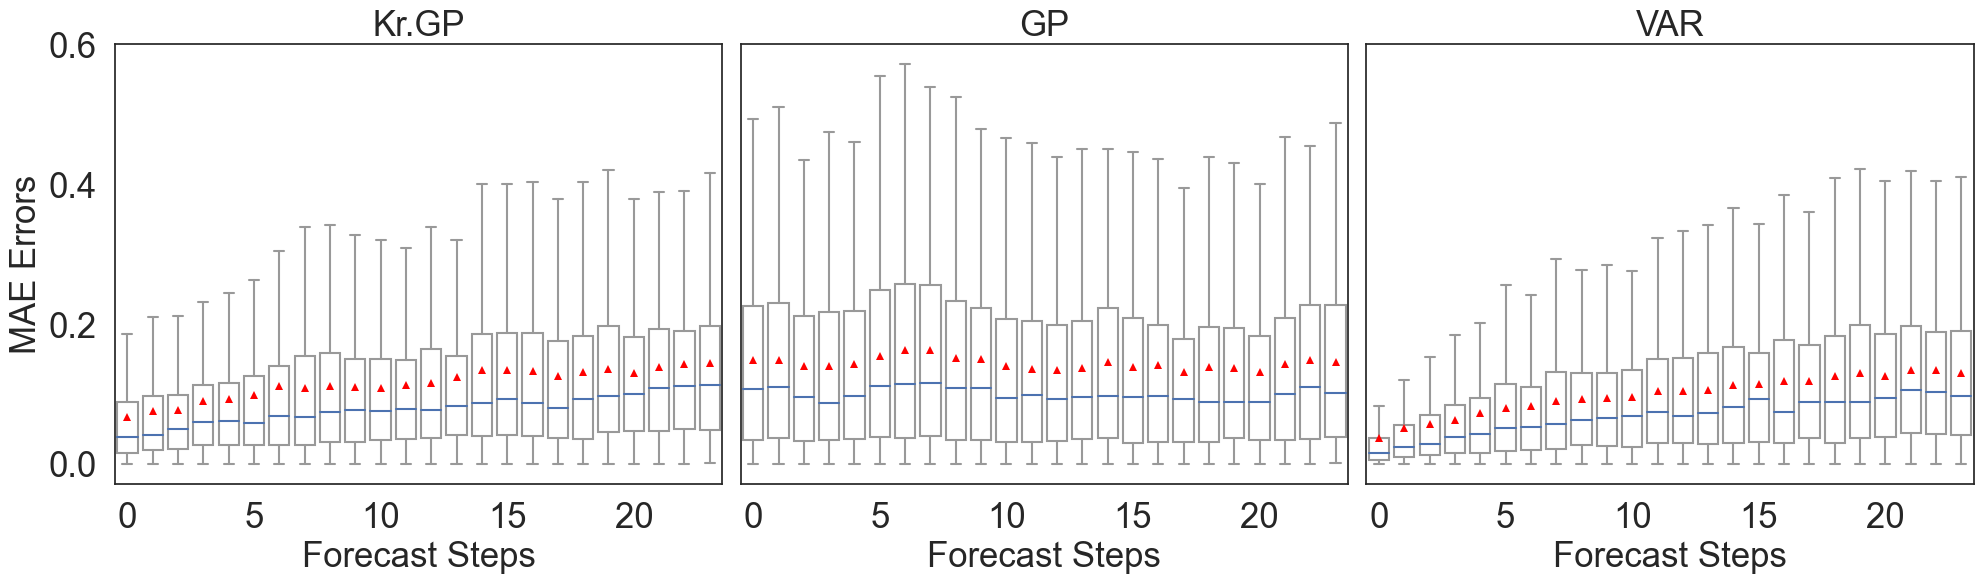

In [555]:
boxplot_forecast_horizon(best_model_dict)

In [556]:
def winter_idx(experiment_idx, n_systems=6):
    return [idx for idx in experiment_idx if idx < 9*n_systems or idx > 48*n_systems]

def spring_idx(experiment_idx, n_systems=6):
    return [idx for idx in experiment_idx if idx > 9*n_systems and idx <= 22*n_systems]

def summer_idx(experiment_idx, n_systems=6):
    return [idx for idx in experiment_idx if idx > 22*n_systems and idx <= 35*n_systems]

def autumn_idx(experiment_idx, n_systems=6):
    return [idx for idx in experiment_idx if idx > 35*n_systems and idx <= 48*n_systems]

def get_season_idx(idx, season :str, n_systems=6):
    if season == 'winter':
        return winter_idx(idx, n_systems)
    elif season == 'spring':
        return spring_idx(idx, n_systems)
    elif season == 'summer':
        return summer_idx(idx, n_systems)
    elif season == 'autumn':
        return autumn_idx(idx, n_systems)
    else:
        raise ValueError('Season must be one of: winter, spring, summer, autumn')


def plot_percent_dict(dct, models=['KroeneckerGP', 'SimpleGP']):
    fig, ax = plt.subplots(1, 4, figsize=(15, 4), sharex=True)

   

    ax = ax.flatten()
    plt.rcParams.update({'font.family': 'Arial'})

    for i, season in enumerate(['winter', 'spring', 'summer', 'autumn']):

        idx = [int((col.split('pct')[-1])) for col in dct[model].columns for model in models]

        dict_season = {model: dct[model].iloc[:, get_season_idx(idx, season)] for model in models}

        sns.histplot(dict_season['KroeneckerGP'].T, ax=ax[i], label='Kroenecker GP', alpha=0.3, palette='tab10',
                     bins=12, legend='Kroenecker GP')
        sns.histplot(dict_season['SimpleGP'].T, ax=ax[i], label='Simple GP', alpha=0.3, palette='husl',
                     bins=12, legend='Simple GP')

        c_gp = sns.color_palette('husl')[0]
        ax[i].axvline(dict_season['KroeneckerGP'].median().median(), color='tab:blue', linestyle='-.',
                       label='Kroenecker GP Median')
        ax[i].axvline(dict_season['SimpleGP'].median().median(), color=c_gp, linestyle='--',
                       label='Simple GP Median')
       
        title = season.upper()[0] + season[1:]
        ax[i].set_title(title, fontsize=20)
        ax[i].set_xlabel('PV Values Inside 95% CI', fontsize=15)
       
        if i == 0:
            # get legends and set at the top middle of the entire figure instead of each subplot
            # set it in a shaded box with edgecolor='black'
            handles, labels = ax[i].get_legend_handles_labels()
            fig.legend(handles, labels, loc='upper center', ncol=5, fontsize=20,
                        bbox_to_anchor=(0.5, 1.2), fancybox=True, shadow=True, edgecolor='black',
                        frameon=True, framealpha=1.0)
            ax[i].set_ylabel('Count 2 Hours', fontsize=15)
            ax[i].yaxis.set_tick_params(labelsize=15)
            # remove legend
            ax[i].legend().remove()
        else:
            # remove legend
            ax[i].legend().remove()
            # remove yticks and yticklabels
            ax[i].set_yticks([])
            ax[i].set_ylabel('')

        ax[i].set_xticks(range(0, 101, 20))  # Set the tick locations as numerical values
        ax[i].set_xticklabels([f'{i}%' for i in range(0, 101, 20)], fontsize=15)  # Set the tick labels as formatted strings

        ax[i].yaxis.set_tick_params(labelsize=15)



    plt.tight_layout()
    plt.savefig(f'percent_inside_ci_temp.png', dpi=300, bbox_inches='tight')
    plt.show()

==> Loading data
==> Loaded data in: 0 m : 0 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



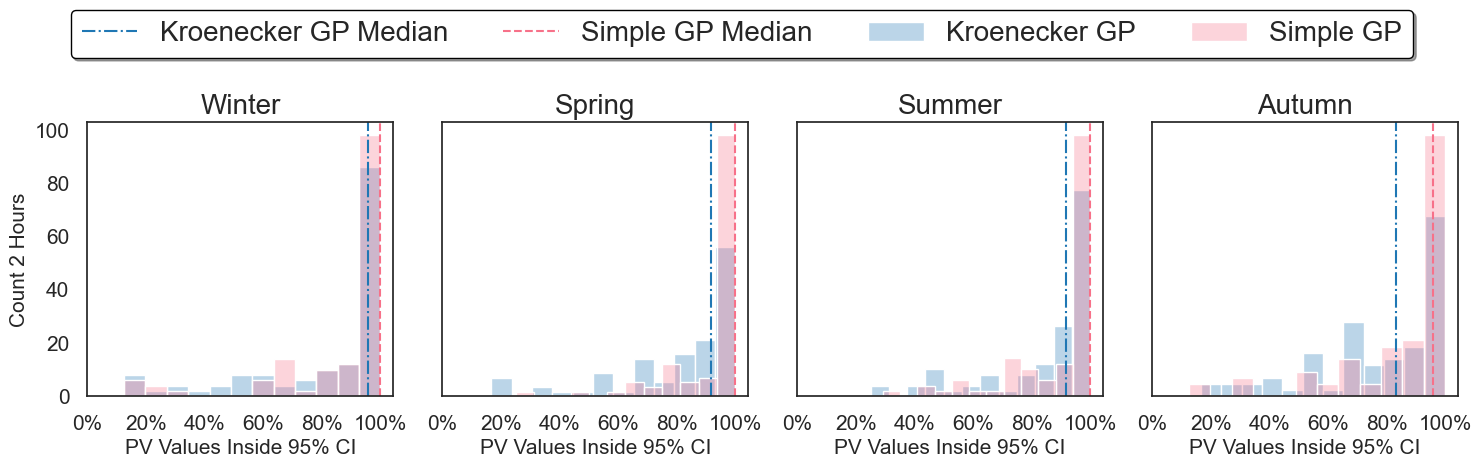

In [557]:
pct_dict = {}
for model in ['KroeneckerGP', 'SimpleGP']:
    pct_dict[model] = load_data('Dissertation/reports/temporal2hr', f'{model}_pct.csv')
    pct_dict[model].drop(columns=['Unnamed: 0'], inplace=True)

plot_percent_dict(pct_dict)

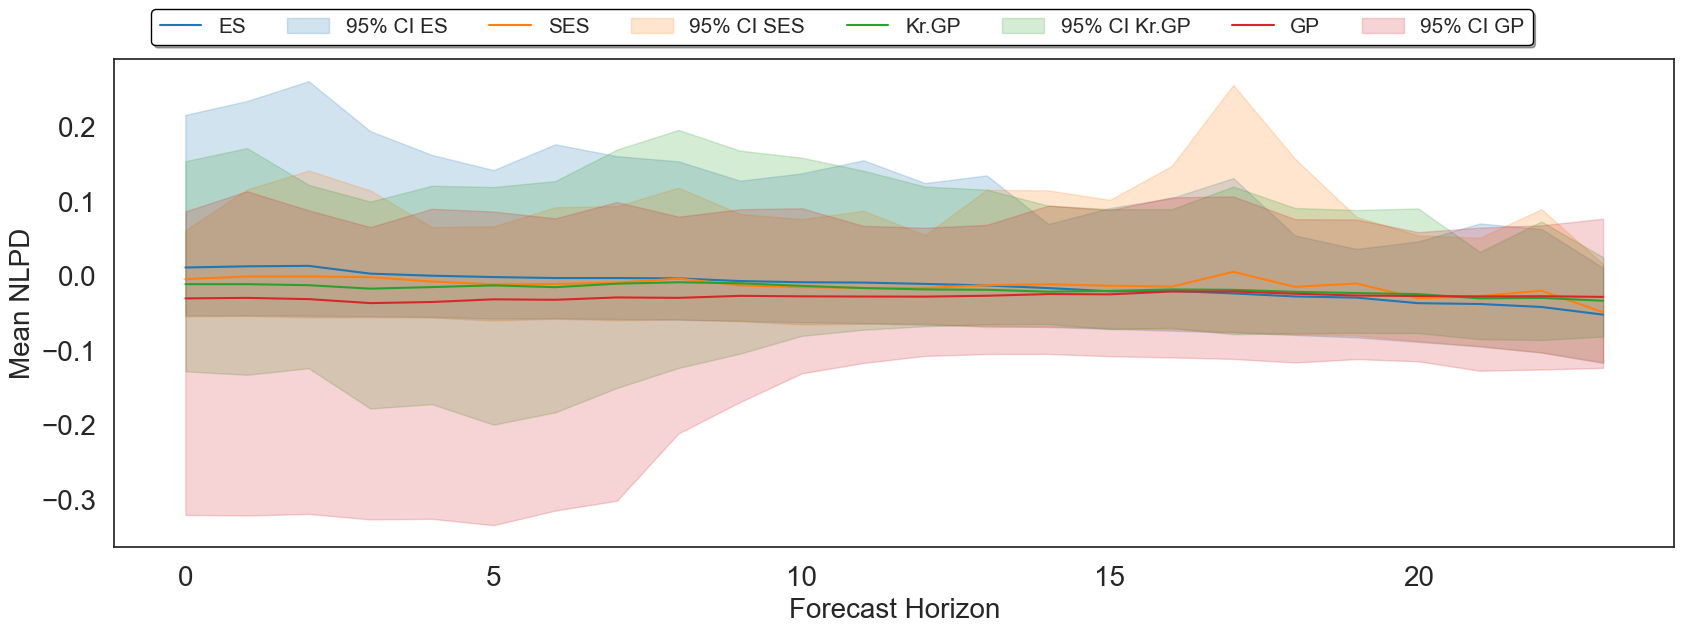

In [596]:
def plot_nlpd_horizon(nlpd_dict):
    fig, ax = plt.subplots(1, 1, figsize=(17, 6))
    # get list of tab10 colors of length of nlpd_dict
    color_list = sns.color_palette('tab10', len(nlpd_dict))
    plt.rcParams.update({'font.family': 'Arial'})
    x = np.arange(0, len(nlpd_dict['Kr.GP'].mean(axis=1)))
    for i, (key, df) in enumerate(nlpd_dict.items()):
        # get row-wise mean
        mean = df.mean(axis=1) 
        lower, upper = df.quantile(0.025, axis=1), df.quantile(0.975, axis=1)
    
        ax.plot(x, mean[::-1], label=key, color=color_list[i])
        ax.fill_between(x, lower[::-1], upper[::-1], alpha=0.2, color=color_list[i], label=f'95% CI {key}')
    
    ax.xaxis.set_tick_params(labelsize=20)
    
    ax.set_ylabel('Mean NLPD', fontsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    ax.set_xlabel('Forecast Horizon', fontsize=20)
    ax.xaxis.set_tick_params(labelsize=20)

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=8, fontsize=15,
                        bbox_to_anchor=(0.5, 1.07), fancybox=True, shadow=True, edgecolor='black',
                        frameon=True, framealpha=1.0)

        
    plt.tight_layout() 
    plt.savefig('nlpd_temporal.png', dpi=300, bbox_inches='tight')
    plt.show();

plot_nlpd_horizon(nlpd_dict)